Import all necessary libraries and install everything you need for training:

In [2]:
# install the libraries necessary for data wrangling, prediction and result analysis
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel
import json
import gc
import torch

### Import the data

In [ ]:
## CORE
dataset = "CORE"

train_df = pd.read_csv("data/CORE_final_train.csv")
dev_df = pd.read_csv("data/CORE_final_dev.csv")
test_df = pd.read_csv("data/CORE_final_test.csv")

print("CORE train shape: {}, Dev shape: {}, Test shape: {}.".format(train_df.shape, dev_df.shape, test_df.shape))

CORE train shape: (20350, 2), Dev shape: (6784, 2), Test shape: (6784, 2).


I'll also experiment with a smaller dev_df as prediction of 6700 examples takes more than 2 hours.

In [5]:
remainder,new_dev_df= train_test_split(dev_df, test_size=1000, random_state=42, shuffle = True, stratify = dev_df.labels)

In [6]:
new_dev_df.describe()

,text,labels
count,1000,1000
unique,1000,12
top,Read what our clients are saying! Thank you ve...,News
freq,1,373


In [7]:
new_dev_df.labels.value_counts()

News                       373
Opinion/Argumentation      265
Information/Explanation    100
Forum                       92
Review                      50
Instruction                 35
Promotion                   30
Research Article            24
Interview                   12
Prose                        8
Legal/Regulation             6
Recipe                       5
Name: labels, dtype: int64

In [8]:
dev_df = new_dev_df
dev_df.describe()

,text,labels
count,1000,1000
unique,1000,12
top,Read what our clients are saying! Thank you ve...,News
freq,1,373


# GINCO
dataset = "GINCO"

train_df = pd.read_csv("data/SI_GINCO_train.csv")
dev_df = pd.read_csv("data/SI_GINCO_dev.csv")
test_df = pd.read_csv("data/SI_GINCO_test.csv")

print("GINCO train shape: {}, Dev shape: {}, Test shape: {}.".format(train_df.shape, dev_df.shape, test_df.shape))

In [9]:
# Create a list of labels
LABELS = train_df.labels.unique().tolist()
LABELS

['Opinion/Argumentation',
 'News',
 'Review',
 'Information/Explanation',
 'Promotion',
 'Instruction',
 'Recipe',
 'Research Article',
 'Forum',
 'Legal/Regulation',
 'Interview',
 'Prose']

## Hyperparameter Search

### Base-sized XLM-RoBERTa

We will use the multilingual XLM-RoBERTa model
https://huggingface.co/xlm-roberta-base

In [10]:
results_hyperparameter_search = []

In [11]:
# Let's save the results to the previous results file:

previous_results_file = open("hyperparameter-search-results.json")
previous_results = json.load(previous_results_file)
len(previous_results)

12

1. experiments with GINCO:
* epoch_set_GINCO: optimum epoch 60
* lr_set_GINCO: optimum lr 1e-5

2. experiments with CORE:
* epoch_set_CORE: optimum epoch 9
* lr_set_CORE: optimum lr 1e-5

In [12]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# Define which hyperparameter are you experimenting with:
hyp_name = "lr"

# Set the hyperparameter values you want to try:
lr_set_GINCO = [1e-6, 1e-5, 1e-4]
lr_set_CORE = [1e-6, 1e-5, 1e-4] 
epoch_set_GINCO = [30, 60, 90, 120]
epoch_set_CORE = [3, 6, 9, 12, 15]


# For each experiment, change one hyperparameter and substitute it with "hyperparameter_set"
hyperparameter_set = lr_set_CORE

for hyperparameter in hyperparameter_set:
    
        # Define the model
        roberta_base_model = ClassificationModel(
        "xlmroberta", "xlm-roberta-base",
        num_labels=len(LABELS),
        use_cuda=True,
        args= {
             "overwrite_output_dir": True,
             "num_train_epochs": 9,
             "labels_list": LABELS,
             "learning_rate": hyperparameter,
             "no_cache": True,
             "no_save": True,
             "max_seq_length": 512,
             "save_steps": -1,
             "use_multiprocessing": True,
             "use_multiprocessing_for_evaluation":True,
             }
        )
        
        # Train the model on train data
        roberta_base_model.train_model(train_df)

        # Evaluate te model on dev data
        
            # Get the true labels from the dev
        y_true = dev_df.labels
        
            # Calculate the model's predictions on dev
        #y_pred = roberta_base_model.predict(dev_df.text.tolist())[0]

        y_pred = []

        pred_counter = 0

        for text in dev_df.text.tolist():
            pred_counter += 1
            print("Prediction of text", pred_counter)
            individual_y_pred = roberta_base_model.predict([text])[0]
            y_pred.append(individual_y_pred[0])

        # Calculate the scores
        macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
        micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
        print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")
        
        # Plot the confusion matrix:
        cm = confusion_matrix(y_true, y_pred, labels=LABELS)
        plt.figure(figsize=(9, 9))
        plt.imshow(cm, cmap="Oranges")
        for (i, j), z in np.ndenumerate(cm):
            plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
        classNames = LABELS
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        tick_marks = np.arange(len(classNames))
        plt.xticks(tick_marks, classNames, rotation=90)
        plt.yticks(tick_marks, classNames)
        plt.title(f"Hyperparameter Search on {dataset}, {hyp_name}:{hyperparameter}")
        
        plt.tight_layout()
        fig1 = plt.gcf()
        plt.show()
        plt.draw()
        fig1.savefig(f"Hyperparameter-search-{dataset}-{hyp_name}-{hyperparameter}.png",dpi=100)

        # Save the results:
        rezdict = {
            "corpus": dataset,
            "hyperparameter":hyp_name,
            "hyp_value":hyperparameter,
            "microF1": micro,
            "macroF1": macro,
            "y_true": y_true.tolist(),
            "y_pred": y_pred,
            }
        results_hyperparameter_search.append(rezdict)
        previous_results.append(rezdict)

        #Save intermediate results (just in case)
        backup = []
        backup.append(rezdict)
        with open(f"backup-results-{dataset}-{hyp_name}-{hyperparameter}.json", "w") as backup_file:
            json.dump(backup,backup_file, indent= "")

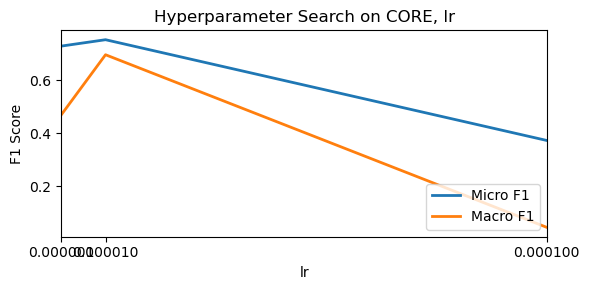

In [14]:
# After the loop, compare the results:
#plt.style.use('_mpl-gallery')

x = []
mi = []
ma = []

for i in results_hyperparameter_search:
    if i["hyperparameter"] == hyp_name and i["corpus"] == dataset:
        x.append(i["hyp_value"])
        mi.append(i['microF1'])
        ma.append(i["macroF1"])

# plot
fig, ax = plt.subplots(figsize=(6,3), dpi=100)

ax.plot(x, mi, linewidth=2.0, label="Micro F1")
ax.plot(x, ma, linewidth=2.0, label="Macro F1")

ax.set(xlim=(min(x), max(x)),xticks=x)

ax.set_xlabel(f'{hyp_name}')
ax.set_ylabel('F1 Score')
ax.legend(loc="lower right")

plt.title(f"Hyperparameter Search on {dataset}, {hyp_name}")
plt.tight_layout()
plt.savefig(f"Hyperparameter-search-{dataset}-{hyp_name}.png")
plt.show()

In [17]:
# Save the file with updated results.
with open("hyperparameter-search-results.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

In [ ]:
gc.collect()
torch.cuda.empty_cache()